In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from tqdm import tqdm

import stimuli
from torchdeepretina.io import load_model


f2_response is unavailable until you run:
$ pip install -e git+git://github.com/nirum/jetpack.git@master#egg=jetpack


In [2]:
prename = "convgc_"
prepath = '/home/grantsrb/src/torch-deep-retina/models/'
savefolder = "FigureUpdates_March2023/"
caption_file = "captions.txt"

path_to_data = "/home/TRAIN_DATA/"
nat_color = 'lightcoral'
whit_color = '#888888'

In [3]:
captions = dict()

In [4]:
def motion_sweep(xstop, speed=0.24):
    """Sweeps a bar across the screen."""
    c, _, X = stimuli.driftingbar(speed=speed, x=(-40, xstop))
    centers = c[40:]
    return centers, stimuli.concat(X)


def sqz(mdls, X):
    """Squeeze predictions from multiple models into one array."""
    X = torch.FloatTensor(X).cuda()
    preds = []
    for mdl in mdls:
        mdl.cuda()
        mdl.eval()
        pred = mdl(X).detach().cpu().numpy()
        preds.append(pred)
        mdl.cpu()
    return np.hstack(preds)


def run_motion_reversal(x_locations, models, speed=0.19, clip_n=210, scaling=1):
    """Gets responses to a bar reversing motion."""
    # tflips is a list of the timings of the direction changes
    # Xs is a list of the motion_reversal stimuli
    tflips, Xs = zip(*[stimuli.motion_reversal(xi,speed)[1:] for xi in x_locations])
    # The model responses to the different motion_reversal stimuli
    data = [sqz(models, scaling*X) for X in tqdm(Xs)]
    fps = 0.01
    time = np.linspace(-tflips[0], (len(Xs[0])-tflips[0]), len(Xs[0]))
    time = time*fps
    deltas = np.array(tflips) - np.array(tflips)[0]
    datacut = [data[0]] + [data[i][deltas[i]:-deltas[i]] for i in range(1, len(deltas))]
    cn = int((datacut[0].shape[0]-clip_n)//2)
    t = time[cn:-cn]
    data_clipped = [d[cn:-cn].T for d in datacut]
    resps = np.stack(data_clipped,axis=-1)
    mu = resps.mean(-1)
    sig = resps.std(-1) / np.sqrt(resps.shape[-1])

    clip_n = len(data_clipped[0])
    #offset = 40//2
    #speed = 0.01
    #t = np.linspace(-clip_n//2 * speed , clip_n//2 * speed, clip_n) + offset*speed
    return t, mu, sig, deltas, resps


def run_motion_sweep(x_locations, models, deltas, speed=0.24, clip_n=210):
    """Gets responses to a bar sweeping across the screen (no reversal)."""
    Xs = [motion_sweep(40 + xi,speed=speed)[1] for xi in x_locations]
    rs = [sqz(models, X) for X in tqdm(Xs)]
    rcut = [rs[0]] + [rs[i][deltas[i]:-deltas[i]] for i in range(1, len(deltas))]
    #cn = int((rcut[0].shape[0]-clip_n)//2)
    R = np.hstack([r[:clip_n] for r in rcut])
    print("R:", R.shape)

    mu = R.mean(axis=1)
    print("mu:", mu.shape)
    sig = R.std(axis=1) / np.sqrt(60)
    offset = 0
    #speed = 0.01
    t = np.linspace((-clip_n//2 + offset) * speed , (clip_n//2 + offset) * speed , clip_n)

    return t, mu, sig




In [5]:
dsets = [ "15-10-07", "15-11-21a", "15-11-21b", ]
stypes = ["naturalscene", "whitenoise"]
ns_mdls = []
wn_mdls = []
for dset in dsets:
    ns_mdls.append(load_model(prepath+prename+dset+"_"+"naturalscene"+".pt"))
    wn_mdls.append(load_model(prepath+prename+dset+"_"+"whitenoise"+".pt"))

In [6]:
# For the figure in the paper, use only the 15-10-07 models
#speed = 0.14
#xs = np.arange(-9, 3)
#scale = 1

speed = 0.15
scale = 1
xs = np.arange(-20, 20)

resps = {
    "whitenoise": [],
    "naturalscene": [],
}

# Plot
clip_n = 210

t, mu, sig, deltas, resp = run_motion_reversal(xs, ns_mdls, speed, clip_n=clip_n, scaling=scale)
for ci in range(resp.shape[0]):
    resps["naturalscene"].append({
        "speed": speed,
        "scale": scale,
        "t": t,
        "mu": mu[ci],
        "sig": sig[ci],
        "deltas": deltas,
    })

t, mu, sig, deltas, resp = run_motion_reversal(xs, wn_mdls, speed, clip_n=clip_n, scaling=scale)
for ci in range(resp.shape[0]):
    resps["whitenoise"].append({
        "speed": speed,
        "scale": scale,
        "t": t,
        "mu": mu[ci],
        "sig": sig[ci],
        "deltas": deltas
    })


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.57it/s]


In [7]:
colors = {
    "whitenoise": whit_color,
    "naturalscene": nat_color,
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


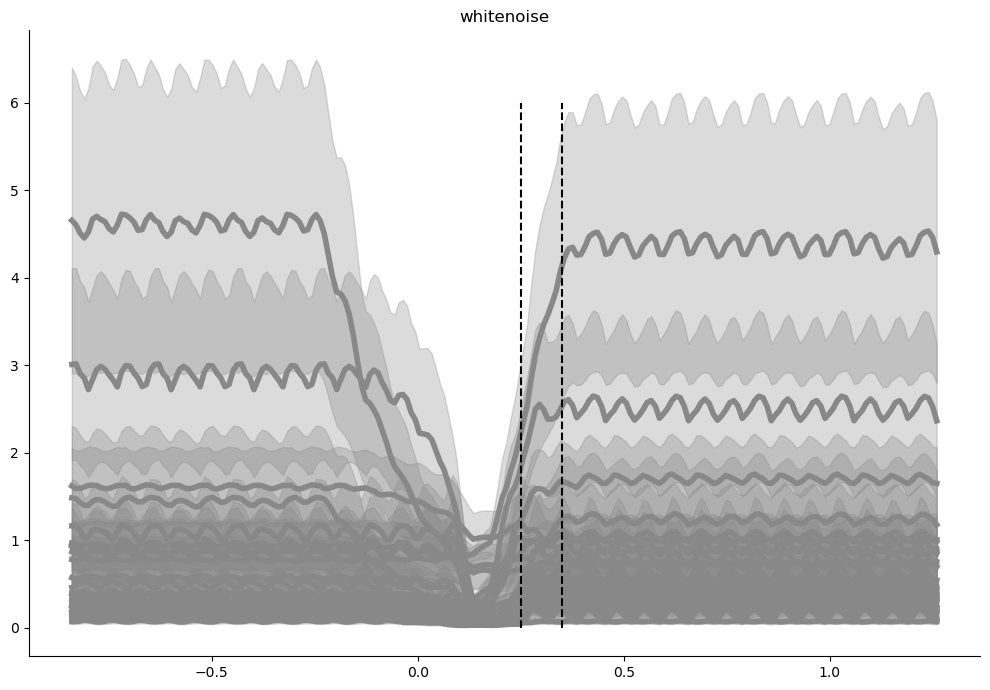

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


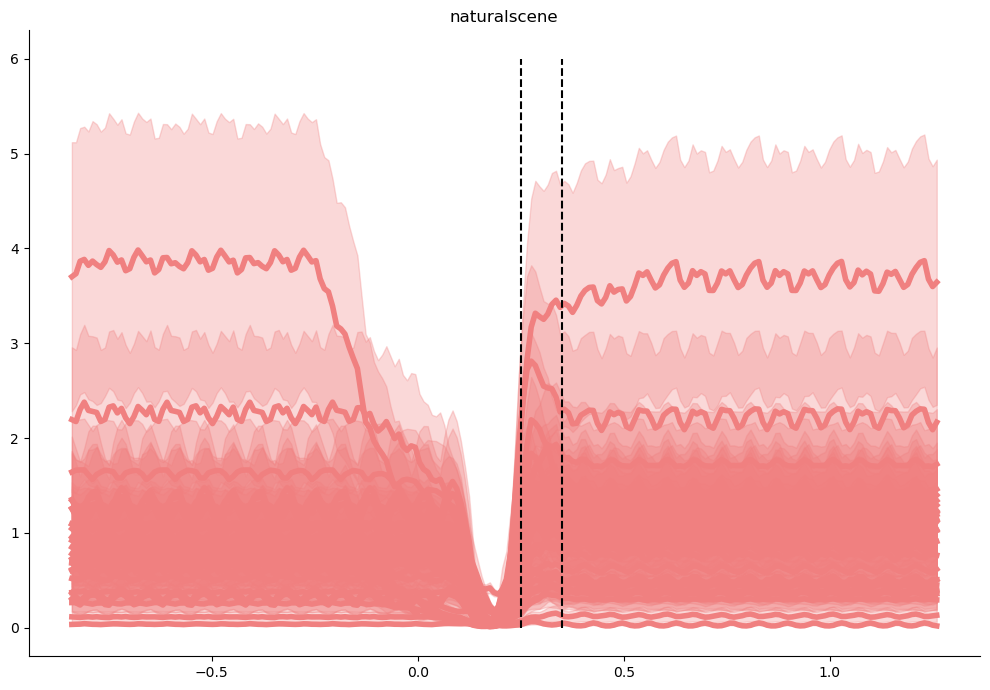

In [8]:
for stype in resps.keys():
    fig = plt.figure(figsize=(10, 7))
    ax = plt.gca()
    color = colors[stype]
    d = resps[stype]
    for ci in range(len(d)):
        mu = d[ci]["mu"]
        sig = d[ci]["sig"]
        t = d[ci]["t"]
        
        # Plot motion reversal response.
        ax.fill_between(t, mu-sig, mu+sig, color=color, alpha=0.3)
        ax.plot(t,mu,color=color, linewidth=4)
        
    ax.plot([0.25,0.25], [0, 6], "--k")
    ax.plot([0.35,0.35], [0, 6], "--k")
    #ax.set_xlim(-.7, 1.1)
    #ax.set_ylim(0, 8)
    #ax.set_ylabel('Firing Rate (Hz)',fontsize=20)
    #ax.set_xlabel('Time (s)',fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.tick_params(axis='both', which='major', labelsize=35)
    #plt.locator_params(nbins=3)
    #plt.yticks(ticks=[0,5])
    #plt.xticks(ticks=[-0.5, 0, 0.5, 1], labels=[-0.5, 0, 0.5, 1])
    plt.legend().set_visible(False)
    plt.title(stype)
    
    #ax.annotate('White Noise', xy=(0.45, 0.75), #xycoords='axes points',
    #            xycoords="figure fraction",
    #            size=30, ha='left', va='top',
    #            bbox=None,
    #            color=whit_color)
    #            
    #ax.annotate('Natural Scenes', xy=(0.45, 0.82), #xycoords='axes points',
    #            xycoords="figure fraction",
    #            size=30, ha='left', va='top',
    #            bbox=None,
    #            color=nat_color)
        
    #l = plt.legend(['Natural Scenes', "White], fontsize=35, frameon=False,
    #                                            handlelength=0,
    #                                            markerscale=0)
    #colors = [nat_color]
    #for color,text in zip(colors, l.get_texts()):
    #    text.set_color(color)
    
    plt.tight_layout()
    plt.show()
    #plt.savefig("mot_rev/"+prename+'motion_reversal'+str(scale)+'.png')
    #plt.savefig("mot_rev/"+prename+'motion_reversal'+str(scale)+'.pdf')
            
        

In [9]:
# Calculate the ratio of the peak firing rate to the mean of the firing rate following the peak
ratios = { }
for stype in resps.keys():
    d = resps[stype]
    ratios[stype] = []
    for ci in range(len(d)):
        mu = d[ci]["mu"]
        peak_window = [0.25, 0.35]
        idxs = (t>peak_window[0])&(t<peak_window[1])
        peak_mu = mu[idxs].mean()
        baseline = mu[t>peak_window[1]].mean()
        ratio = peak_mu/baseline
        ratios[stype].append(ratio)

In [10]:
ns_df = pd.DataFrame({
    "stype": ["naturalscene" for _ in range(len(ratios["naturalscene"]))],
    "ratio": ratios["naturalscene"],
})
wn_df = pd.DataFrame({
    "stype": ["whitenoise" for _ in range(len(ratios["whitenoise"]))],
    "ratio": ratios["whitenoise"],
})
df = pd.concat([ns_df, wn_df], sort=True).reset_index()
df.head()

,index,ratio,stype
0,0,1.297774,naturalscene
1,1,1.270332,naturalscene
2,2,1.457105,naturalscene
3,3,1.241343,naturalscene
4,4,1.394418,naturalscene


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


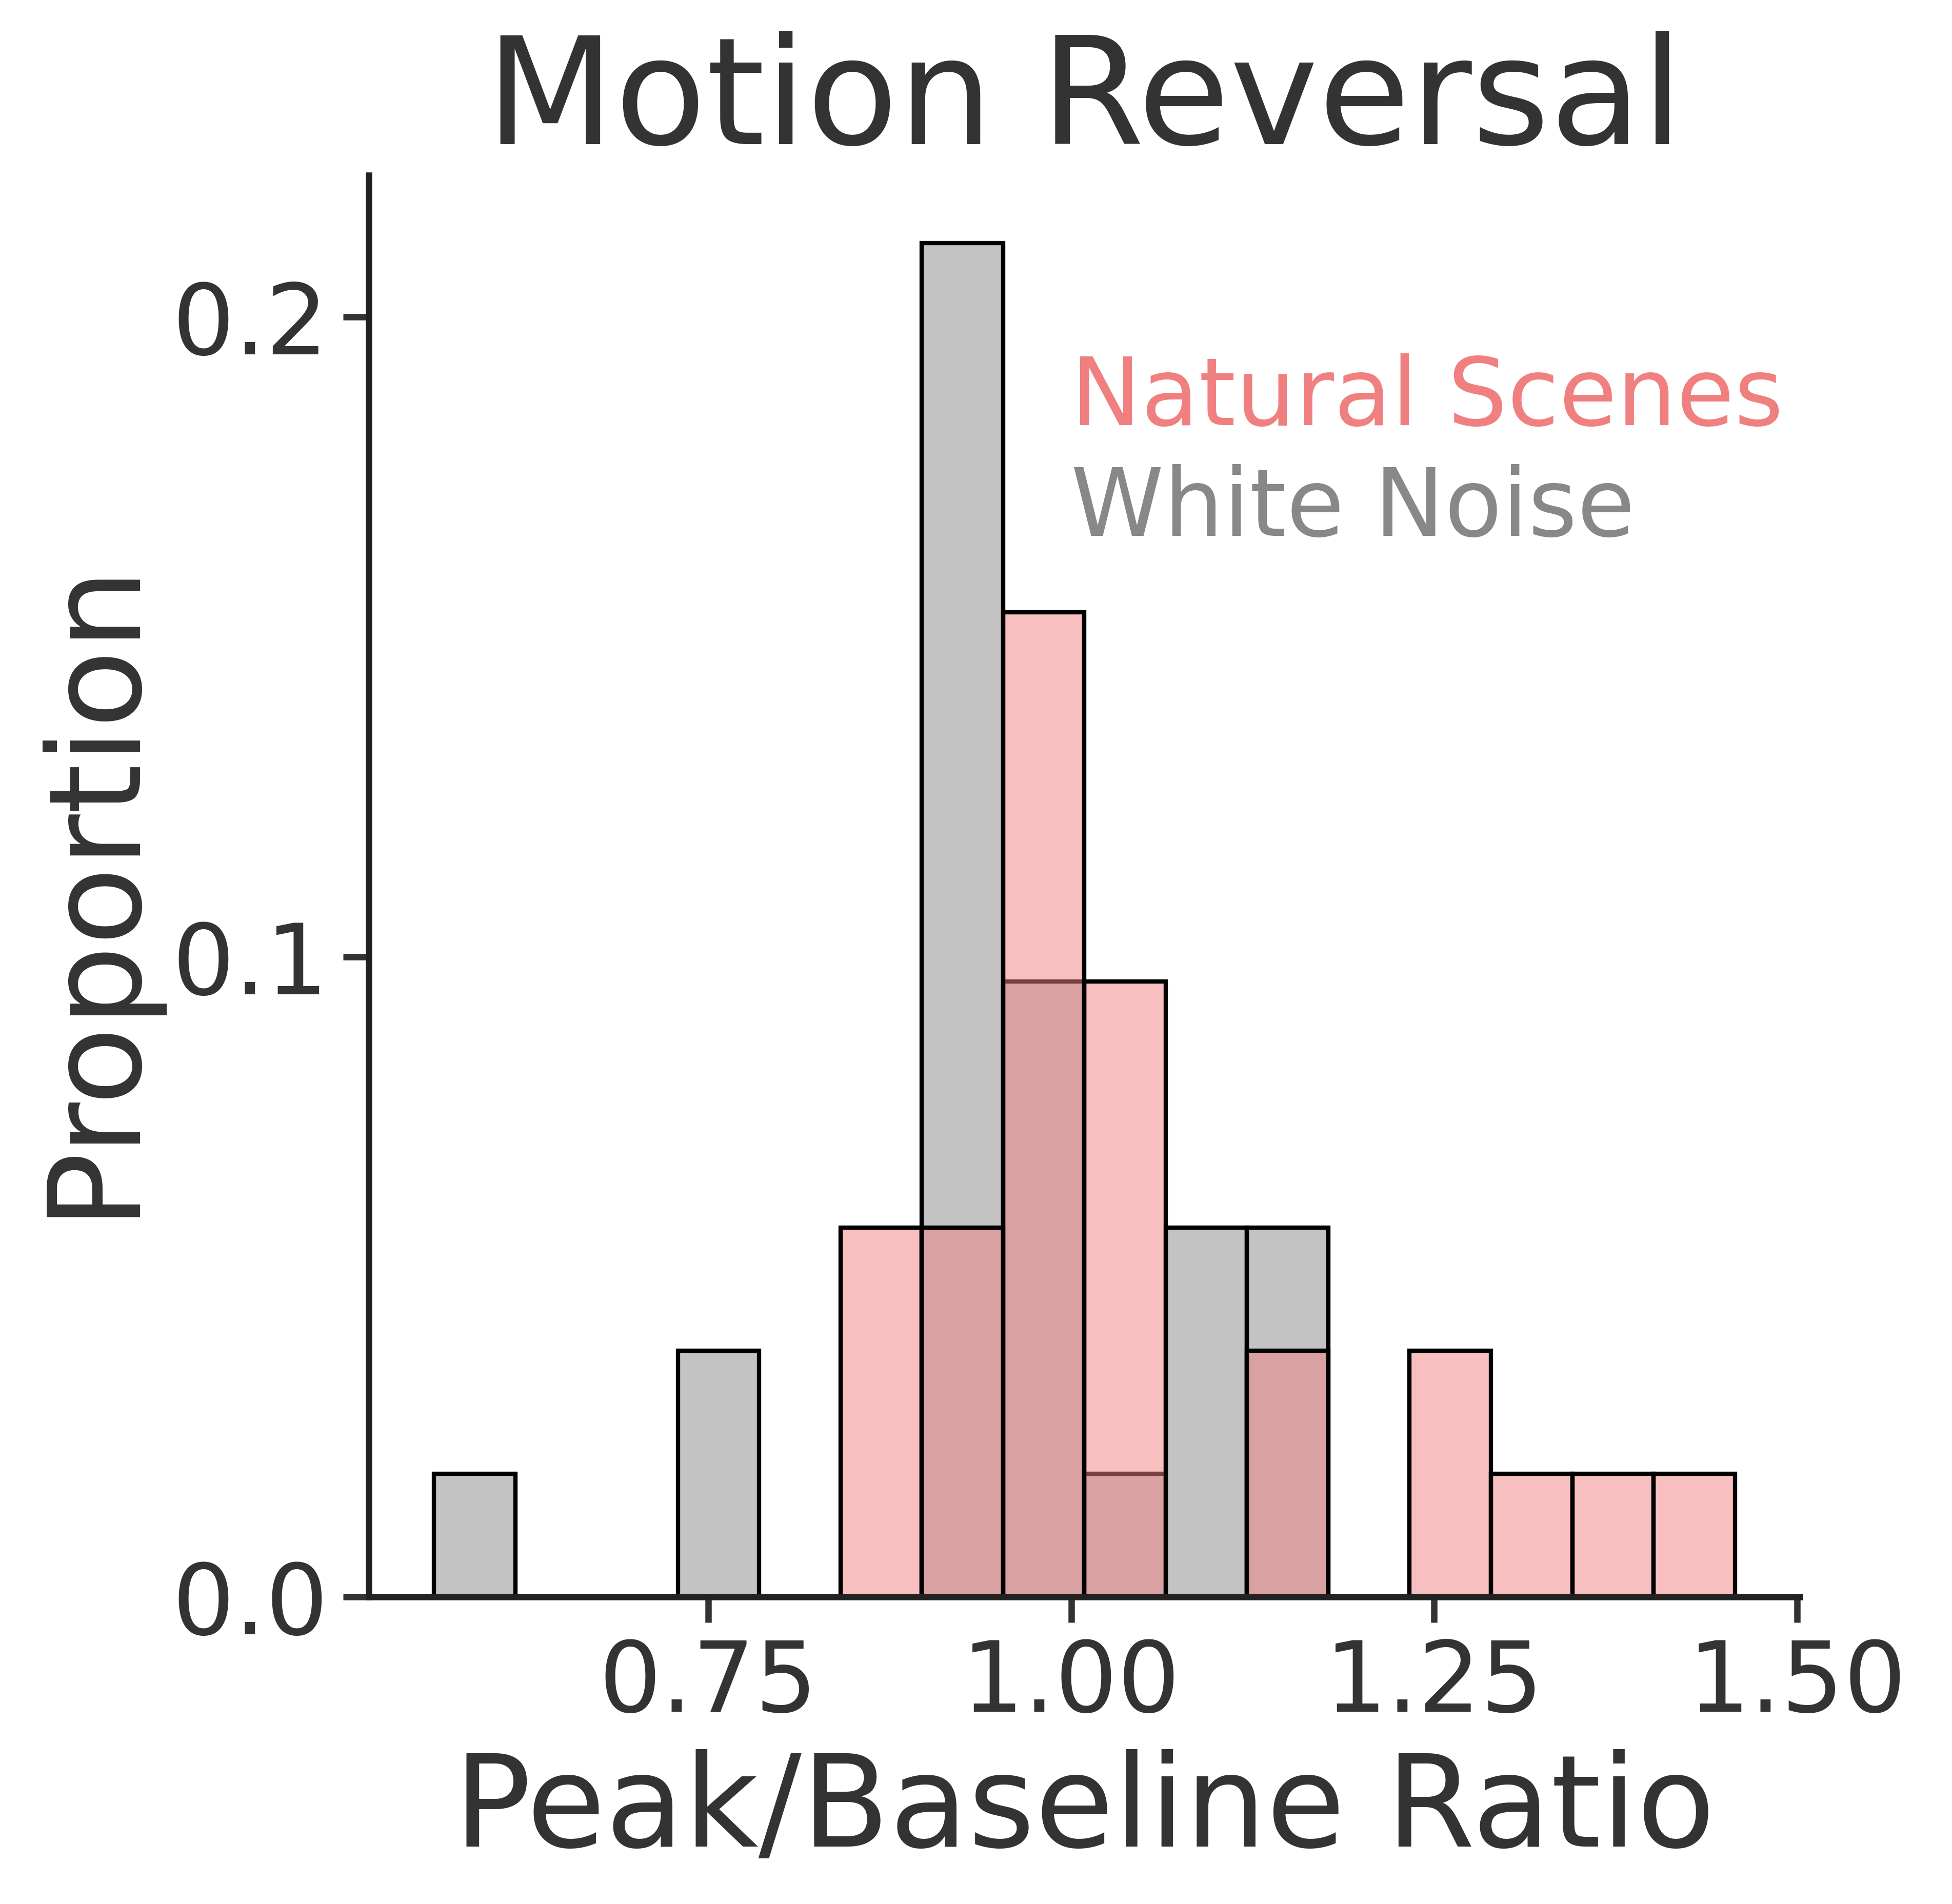

In [12]:
fontsize = 30
titlesize = 35
ticksize = 23
alpha = 1
plt.style.use('deepretina.mplstyle')
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
sns.histplot(x="ratio", hue="stype", data=df, stat="proportion", ax=ax, palette={"whitenoise": whit_color, "naturalscene": nat_color})

plt.xlabel("Peak/Baseline Ratio", fontsize=fontsize)
plt.ylabel("Proportion", fontsize=fontsize)
#plt.yticks([0,0.1,0.2,0.3], fontsize=ticksize)
#plt.xticks([0,0.1,0.2], fontsize=ticksize)
plt.legend().set_visible(False)
plt.title("Motion Reversal", fontsize=titlesize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.locator_params(nbins=4)
ax.tick_params(axis='both', which='major', labelsize=ticksize)

x = 0.58
size = 22
ax.annotate('White Noise', xy=(x, 0.78), #xycoords='axes points',
            xycoords="figure fraction",
            size=size, ha='left', va='top',
            bbox=None,
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(x, 0.84), #xycoords='axes points',
            xycoords="figure fraction",
            size=size, ha='left', va='top',
            bbox=None,
            color=nat_color)
            

folder_name = "motion_rev"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}motion_rev_hist".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[save_name.split("/")[-1]] = """
Histogram of the ratio of the peak motion reversal response to the baseline response following the peak for each cell.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions.items():
        f.write(k+":\n")
        f.write(v+"\n\n")

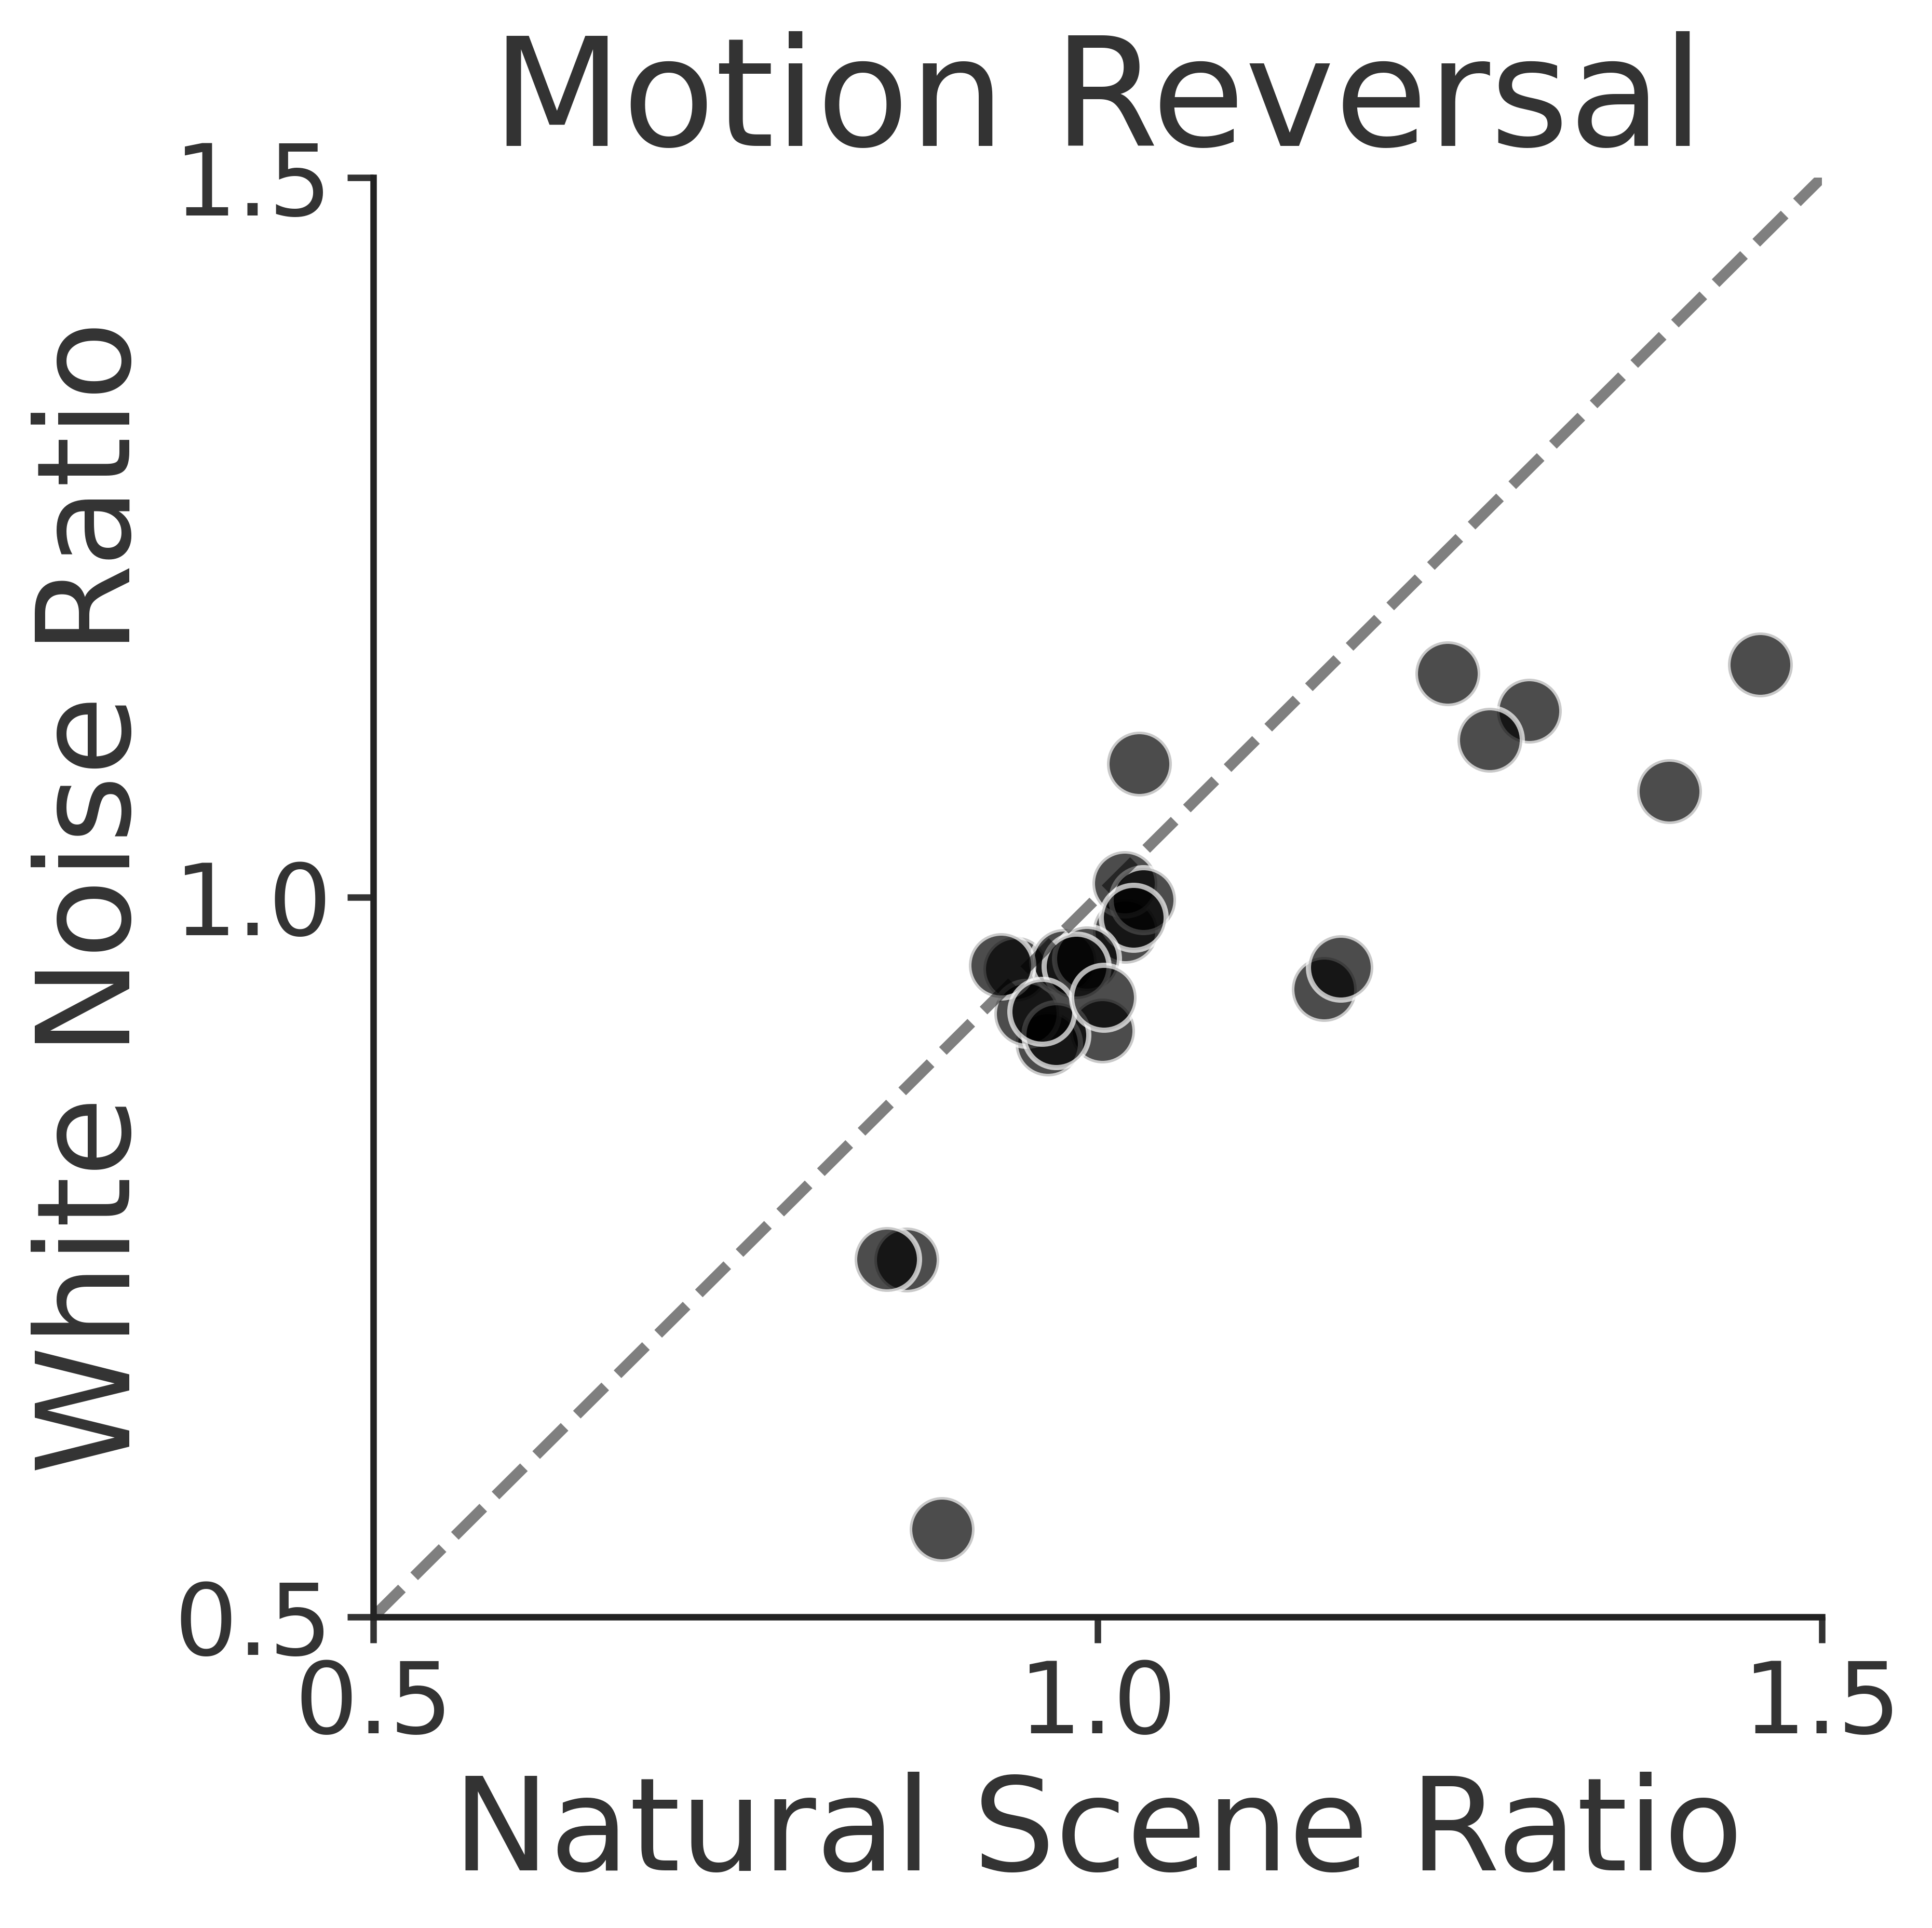

In [13]:
cols = ["index"]
y = np.asarray(df.loc[df["stype"]=="whitenoise"].sort_values(by=cols)["ratio"])
x = np.asarray(df.loc[df["stype"]=="naturalscene"].sort_values(by=cols)["ratio"])

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.scatterplot(x=x,y=y, ax=ax, alpha=0.7, color="black")
ticks = [0.5,1, 1.5]
plt.xticks(ticks, fontsize=ticksize)
plt.yticks(ticks, fontsize=ticksize)
lim = [ticks[0], ticks[-1]]
plt.ylim(lim)
plt.xlim(lim)
ax.plot(np.linspace(lim[0], lim[1], 2), np.linspace(lim[0], lim[1], 2), "--k", alpha=0.5)
plt.ylabel("White Noise Ratio", fontsize=fontsize)
plt.xlabel("Natural Scene Ratio", fontsize=fontsize)
plt.title("Motion Reversal", fontsize=titlesize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "motion_rev"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}motion_rev_scatter".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[save_name.split("/")[-1]] = """
White Noise model peak to baseline ratios plotted against Natural Scenes model peak to baseline ratios for each cell.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions.items():
        f.write(k+":\n")
        f.write(v+"\n\n")

In [ ]:
for stype in resps.keys():
    fig = plt.figure(figsize=(10, 7))
    ax = plt.gca()
    color = colors[stype]
    d = resps[stype]
    for ci in range(len(d)):
        mu = d[ci]["mu"]
        sig = d[ci]["sig"]
        t = d[ci]["t"]
        
        # Plot motion reversal response.
        ax.fill_between(t, mu-sig, mu+sig, color=color, alpha=0.3)
        ax.plot(t,mu,color=color, linewidth=4)
        
    ax.plot([0.15,0.15], [0, 6], "--k")
    ax.plot([0.25,0.25], [0, 6], "--k")
    ax.plot([0.35,0.35], [0, 6], "--k")
    #ax.set_xlim(-.7, 1.1)
    #ax.set_ylim(0, 8)
    #ax.set_ylabel('Firing Rate (Hz)',fontsize=20)
    #ax.set_xlabel('Time (s)',fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.tick_params(axis='both', which='major', labelsize=35)
    #plt.locator_params(nbins=3)
    #plt.yticks(ticks=[0,5])
    #plt.xticks(ticks=[-0.5, 0, 0.5, 1], labels=[-0.5, 0, 0.5, 1])
    plt.legend().set_visible(False)
    plt.title(dtype + " " + stype)
    
    #ax.annotate('White Noise', xy=(0.45, 0.75), #xycoords='axes points',
    #            xycoords="figure fraction",
    #            size=30, ha='left', va='top',
    #            bbox=None,
    #            color=whit_color)
    #            
    #ax.annotate('Natural Scenes', xy=(0.45, 0.82), #xycoords='axes points',
    #            xycoords="figure fraction",
    #            size=30, ha='left', va='top',
    #            bbox=None,
    #            color=nat_color)
        
    #l = plt.legend(['Natural Scenes', "White], fontsize=35, frameon=False,
    #                                            handlelength=0,
    #                                            markerscale=0)
    #colors = [nat_color]
    #for color,text in zip(colors, l.get_texts()):
    #    text.set_color(color)
    
    plt.tight_layout()
    plt.show()
    #plt.savefig("mot_rev/"+prename+'motion_reversal'+str(scale)+'.png')
    #plt.savefig("mot_rev/"+prename+'motion_reversal'+str(scale)+'.pdf')
            
        

ValueError: operands could not be broadcast together with shapes (730,) (210,) 

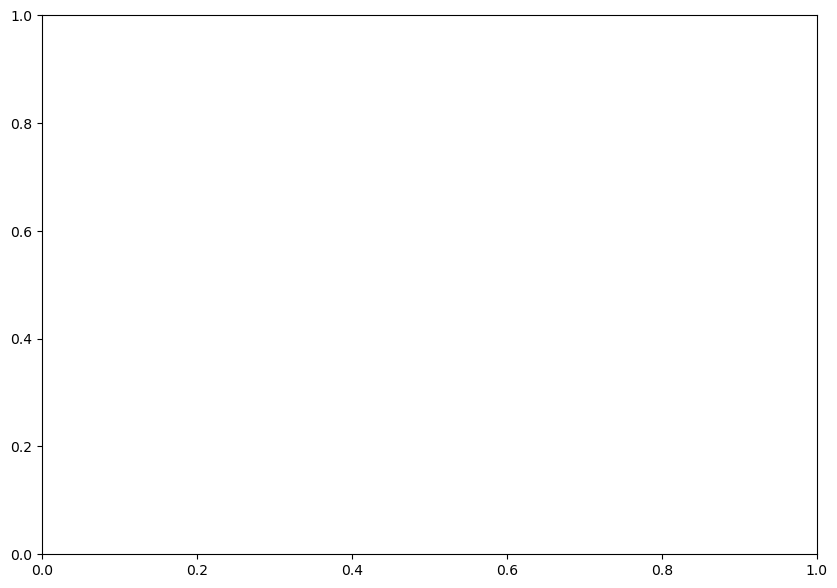

In [37]:
dtype = "15-11-21b"
stype = "naturalscene"

color = colors[stype]
d = resps[dtype][stype]
for ci in range(len(d)):
    fig = plt.figure(figsize=(10, 7))
    ax = plt.gca()
    mu = d[ci]["mu"]
    sig = d[ci]["sig"]
    t = d[ci]["t"]
    
    # Plot motion reversal response.
    ax.fill_between(t, mu-sig, mu+sig, color=color, alpha=0.3)
    ax.plot(t,mu,color=color, linewidth=4)
    
    #ax.set_xlim(-.7, 1.1)
    #ax.set_ylim(0, 8)
    ##ax.set_ylabel('Firing Rate (Hz)',fontsize=20)
    ##ax.set_xlabel('Time (s)',fontsize=20)
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ##ax.spines['left'].set_visible(False)
    #ax.tick_params(axis='both', which='major', labelsize=35)
    #plt.locator_params(nbins=3)
    #plt.yticks(ticks=[0,5])
    #plt.xticks(ticks=[-0.5, 0, 0.5, 1], labels=[-0.5, 0, 0.5, 1])
    plt.legend().set_visible(False)
    plt.title(dtype + " " + stype)
    
    #ax.annotate('White Noise', xy=(0.45, 0.75), #xycoords='axes points',
    #            xycoords="figure fraction",
    #            size=30, ha='left', va='top',
    #            bbox=None,
    #            color=whit_color)
    #            
    #ax.annotate('Natural Scenes', xy=(0.45, 0.82), #xycoords='axes points',
    #            xycoords="figure fraction",
    #            size=30, ha='left', va='top',
    #            bbox=None,
    #            color=nat_color)
        
    #l = plt.legend(['Natural Scenes', "White], fontsize=35, frameon=False,
    #                                            handlelength=0,
    #                                            markerscale=0)
    #colors = [nat_color]
    #for color,text in zip(colors, l.get_texts()):
    #    text.set_color(color)
    
    plt.tight_layout()
    plt.show()
        
    

In [14]:
speed = 0.14
scale = 1
for ns_model, wn_model, dset in zip(ns_mdls,wn_mdls, dsets):
    print("Speed:", speed, "-- Scale:", scale, "-- DataSet:", dset)
    # Plot
    clip_n = 210
    fig = plt.figure(figsize=(10, 7))

    # Plot motion reversal response.
    xs = np.arange(-9, 3)
    t, mu, sig, deltas, resps = run_motion_reversal(xs, (ns_model,), speed, clip_n=clip_n, scaling=scale)
    #sig = np.zeros_like(sig)
    ax = plt.gca()
    ax.fill_between(t, mu-sig, mu+sig, color=nat_color, alpha=0.3)
    ax.plot(t,mu,color=nat_color, linewidth=4)
    #ax.errorbar(t, mu, yerr=sig, color=nat_color)
    #errorplot(t, mu, sig, color=nat_color, ax=ax, linewidth=5)

    t, mu, sig, deltas, resps = run_motion_reversal(xs, (wn_model,), speed, clip_n=clip_n, scaling=scale)
    whit_color = '#888888'
    ax.fill_between(t, mu-sig, mu+sig, color=whit_color, alpha=0.3)
    ax.plot(t,mu,color=whit_color, linewidth=4)
    #ax.errorbar(t, mu, yerr=sig, color=whit_color)
    #errorplot(t, mu, sig, color='lightblue', ax=ax, linewidth=5)

    ax.set_xlim(-.7, 1.1)
    ax.set_ylim(0, 8)
    #ax.set_ylabel('Firing Rate (Hz)',fontsize=20)
    #ax.set_xlabel('Time (s)',fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=35)
    plt.locator_params(nbins=3)
    plt.yticks(ticks=[0,5])
    plt.xticks(ticks=[-0.5, 0, 0.5, 1], labels=[-0.5, 0, 0.5, 1])
    plt.legend().set_visible(False)
    
    #ax.annotate('White Noise', xy=(0.45, 0.75), #xycoords='axes points',
    #            xycoords="figure fraction",
    #            size=30, ha='left', va='top',
    #            bbox=None,
    #            color=whit_color)
    #            
    #ax.annotate('Natural Scenes', xy=(0.45, 0.82), #xycoords='axes points',
    #            xycoords="figure fraction",
    #            size=30, ha='left', va='top',
    #            bbox=None,
    #            color=nat_color)
        
    #l = plt.legend(['Natural Scenes', "White], fontsize=35, frameon=False,
    #                                            handlelength=0,
    #                                            markerscale=0)
    #colors = [nat_color]
    #for color,text in zip(colors, l.get_texts()):
    #    text.set_color(color)

    plt.tight_layout()

    plt.show()
    #plt.savefig("mot_rev/"+prename+'motion_reversal'+str(scale)+'.png')
    #plt.savefig("mot_rev/"+prename+'motion_reversal'+str(scale)+'.pdf')
    break



NameError: name 'dsets' is not defined